# Carbon Prediction

## Importing libraries

In [3]:
import pandas as pd
import numpy as np
# visualization
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
# location
# import geopandas as gpd
# import folium
# models
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
# metrics
from sklearn.metrics import mean_squared_error
# tuning
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV
# utils
import random
from datetime import datetime as dt
import joblib

In [4]:
# Set seed for reproducability
SEED = 22
random.seed(SEED)
np.random.seed(SEED)

## Loading data

In [5]:
DATA_PATH = 'data/'
# Load files
train = pd.read_csv(DATA_PATH + 'Train.csv')
test = pd.read_csv(DATA_PATH + 'Test.csv')
sample_submission = pd.read_csv(DATA_PATH + 'SampleSubmission.csv')

## Previewing data 

In [6]:
# Preview train dataset
train.head()

,ID_LAT_LON_YEAR_WEEK,latitude,longitude,year,week_no,SulphurDioxide_SO2_column_number_density,SulphurDioxide_SO2_column_number_density_amf,SulphurDioxide_SO2_slant_column_number_density,SulphurDioxide_cloud_fraction,SulphurDioxide_sensor_azimuth_angle,...,Cloud_cloud_top_height,Cloud_cloud_base_pressure,Cloud_cloud_base_height,Cloud_cloud_optical_depth,Cloud_surface_albedo,Cloud_sensor_azimuth_angle,Cloud_sensor_zenith_angle,Cloud_solar_azimuth_angle,Cloud_solar_zenith_angle,emission
0,ID_-23.73_28.77_2019_1,-23.73,28.77,2019,1,0.000167,0.713172,0.000102,0.223929,24.939440,...,5566.222019,54826.032616,4606.209995,19.115282,0.353778,24.951948,49.053953,-89.638032,17.988874,86.051700
1,ID_-23.73_28.77_2019_2,-23.73,28.77,2019,2,-0.000155,0.812910,-0.000137,0.080281,16.624162,...,3711.511365,68491.753342,3034.461661,12.218664,0.244987,4.708856,42.586683,-89.904314,22.773246,88.875670
2,ID_-23.73_28.77_2019_3,-23.73,28.77,2019,3,-0.000065,0.860306,-0.000062,0.161050,-13.237244,...,2136.385189,78967.739548,1433.482587,6.062737,0.245102,76.060628,34.737544,-83.595254,17.437300,91.723114
3,ID_-23.73_28.77_2019_4,-23.73,28.77,2019,4,0.000152,0.422284,0.000087,0.046504,-13.534653,...,3841.853018,64592.806769,2878.512917,6.388233,0.210904,75.912368,60.294490,-71.896728,11.977818,92.883870
4,ID_-23.73_28.77_2019_5,-23.73,28.77,2019,5,0.000024,1.004578,0.000028,0.214246,-13.475718,...,1295.688171,86804.025391,1094.665344,9.206252,0.261103,-13.346079,50.194493,-77.462082,24.374270,94.878330


In [7]:
# Preview test dataset
test.head()

,ID_LAT_LON_YEAR_WEEK,latitude,longitude,year,week_no,SulphurDioxide_SO2_column_number_density,SulphurDioxide_SO2_column_number_density_amf,SulphurDioxide_SO2_slant_column_number_density,SulphurDioxide_cloud_fraction,SulphurDioxide_sensor_azimuth_angle,...,Cloud_cloud_top_pressure,Cloud_cloud_top_height,Cloud_cloud_base_pressure,Cloud_cloud_base_height,Cloud_cloud_optical_depth,Cloud_surface_albedo,Cloud_sensor_azimuth_angle,Cloud_sensor_zenith_angle,Cloud_solar_azimuth_angle,Cloud_solar_zenith_angle
0,ID_-23.53_27.47_2019_1,-23.53,27.47,2019,1,0.000077,0.454468,0.000034,0.114291,-80.286309,...,74897.052000,2180.266538,81287.074479,1562.031017,10.734123,0.280660,-31.230174,33.337966,-93.217261,23.358251
1,ID_-23.53_27.47_2019_2,-23.53,27.47,2019,2,0.000181,0.423171,0.000062,0.075100,-17.765690,...,84222.653521,982.619057,90307.650011,927.111222,5.250020,0.238933,66.490898,58.137794,-85.001467,13.416481
2,ID_-23.53_27.47_2019_3,-23.53,27.47,2019,3,0.000059,0.713085,0.000043,0.114210,16.725653,...,78922.490786,1582.964934,85383.151853,1006.778109,6.819371,0.258681,75.923186,41.336951,-83.267543,16.273000
3,ID_-23.53_27.47_2019_4,-23.53,27.47,2019,4,0.000483,0.434454,0.000171,0.131394,-22.475340,...,61135.919587,3935.419981,67490.031362,3428.423528,6.233628,0.281542,-11.023230,60.689869,-77.763718,22.793961
4,ID_-23.53_27.47_2019_5,-23.53,27.47,2019,5,0.000193,0.783044,0.000141,0.161142,4.750356,...,78494.247391,1647.538526,84478.743043,1122.534093,11.810251,0.281564,-13.294513,51.007132,-76.620646,23.198242


In [8]:
# Let’s observe the shape of our datasets.
print('Dimension du train set :', train.shape)
print('Dimension du test set :', test.shape)

Dimension du train set : (74005, 76)
Dimension du test set : (28085, 75)


In [9]:
# Train to test sets ratio
(test.shape[0]) / (train.shape[0] + test.shape[0]) * 100

27.510040160642568

## Statistical summaries

Types des variables

In [10]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74005 entries, 0 to 74004
Data columns (total 76 columns):
 #   Column                                                    Non-Null Count  Dtype  
---  ------                                                    --------------  -----  
 0   ID_LAT_LON_YEAR_WEEK                                      74005 non-null  object 
 1   latitude                                                  74005 non-null  float64
 2   longitude                                                 74005 non-null  float64
 3   year                                                      74005 non-null  int64  
 4   week_no                                                   74005 non-null  int64  
 5   SulphurDioxide_SO2_column_number_density                  72075 non-null  float64
 6   SulphurDioxide_SO2_column_number_density_amf              72075 non-null  float64
 7   SulphurDioxide_SO2_slant_column_number_density            72075 non-null  float64
 8   SulphurDioxide_c

In [11]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28085 entries, 0 to 28084
Data columns (total 75 columns):
 #   Column                                                    Non-Null Count  Dtype  
---  ------                                                    --------------  -----  
 0   ID_LAT_LON_YEAR_WEEK                                      28085 non-null  object 
 1   latitude                                                  28085 non-null  float64
 2   longitude                                                 28085 non-null  float64
 3   year                                                      28085 non-null  int64  
 4   week_no                                                   28085 non-null  int64  
 5   SulphurDioxide_SO2_column_number_density                  27168 non-null  float64
 6   SulphurDioxide_SO2_column_number_density_amf              27168 non-null  float64
 7   SulphurDioxide_SO2_slant_column_number_density            27168 non-null  float64
 8   SulphurDioxide_c

ID and target

In [17]:
ID = 'ID_LAT_LON_YEAR_WEEK'
TARGET = 'emission'

Analyse des variables quantitatives

In [ ]:
train_decription = train.select_dtypes(include='number').describe().T
train_decription

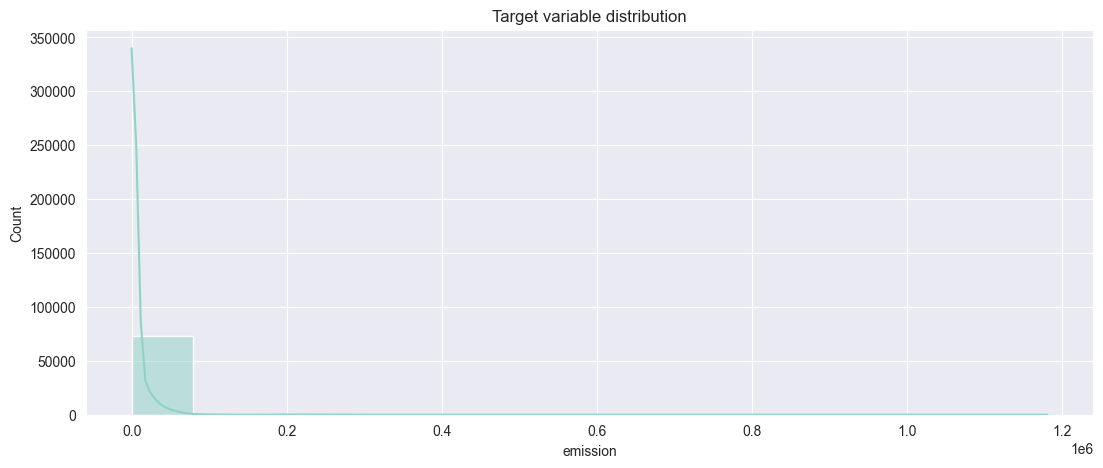

None

17.038027449698163

In [11]:
# Target variable distribution
plt.figure(figsize = (13, 5))
sns.histplot(train[TARGET], kde = True, bins = 15)
plt.title('Target variable distribution')
display(plt.show(), train[TARGET].skew())

## 4. Outliers

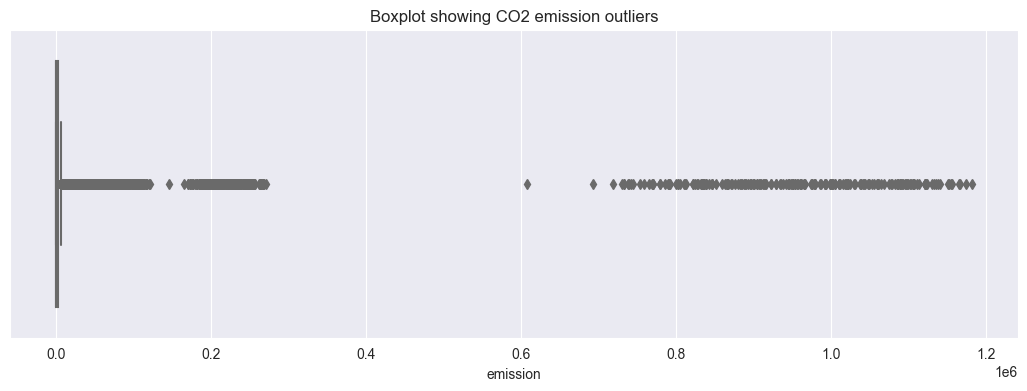

In [18]:
# Plotting boxplot for the CO2 emissions
plt.figure(figsize=(13, 4))
sns.boxplot(x=train[TARGET])
plt.title('Boxplot showing CO2 emission outliers')
plt.show()

## 6. Missing values and duplicates

In [19]:
# Check for duplicates
train.duplicated().any(), test.duplicated().any()

(False, False)

Bien, aucun doublon !

In [20]:
missing_rate = (train.isna().sum() * 100 / train.shape[0]).sort_values()
missing_rate

ID_LAT_LON_YEAR_WEEK                                         0.000000
week_no                                                      0.000000
year                                                         0.000000
emission                                                     0.000000
latitude                                                     0.000000
longitude                                                    0.000000
Ozone_O3_column_number_density                               0.277008
Ozone_O3_slant_column_number_density                         0.277008
Ozone_O3_effective_temperature                               0.277008
Ozone_O3_column_number_density_amf                           0.277008
Ozone_sensor_azimuth_angle                                   0.277008
Ozone_sensor_zenith_angle                                    0.277008
Ozone_solar_azimuth_angle                                    0.277008
Ozone_solar_zenith_angle                                     0.277008
Ozone_cloud_fraction

In [17]:
missing_test = (test.isna().sum() * 100 / test.shape[0]).sort_values()
missing_test

ID_LAT_LON_YEAR_WEEK                           0.000000
UvAerosolIndex_solar_azimuth_angle             0.000000
UvAerosolIndex_sensor_zenith_angle             0.000000
UvAerosolIndex_sensor_azimuth_angle            0.000000
UvAerosolIndex_sensor_altitude                 0.000000
                                                ...    
UvAerosolLayerHeight_sensor_zenith_angle      93.484066
UvAerosolLayerHeight_aerosol_optical_depth    93.484066
UvAerosolLayerHeight_aerosol_pressure         93.484066
UvAerosolLayerHeight_aerosol_height           93.484066
UvAerosolLayerHeight_solar_zenith_angle       93.484066
Length: 75, dtype: float64

In [18]:
# suppression de toutes les colonnes avec plus de 90% de valeurs manquantes
train_full = train[train.columns[train.isna().sum() / train.shape[0] < 0.9]]
train_full = train_full.dropna(axis=0)
train_full.shape

(68699, 69)

In [19]:
# suppression de toutes les colonnes avec plus de 90% de valeurs manquantes
test_full = test[test.columns[test.isna().sum() / test.shape[0] < 0.9]]
# test_full = test_full.dropna(axis=0)
test_full.shape

(28085, 68)

In [20]:
train_full.isna().any().sum()

0

In [21]:
test_full.isna().any().sum()

48

In [22]:
# Train to train_full sets ratio
(train_full.shape[0]) / (train.shape[0]) * 100

92.83021417471792

In [23]:
# Test to test_full sets ratio
(test_full.shape[0]) / (test.shape[0]) * 100

100.0

## 7. Date features EDA

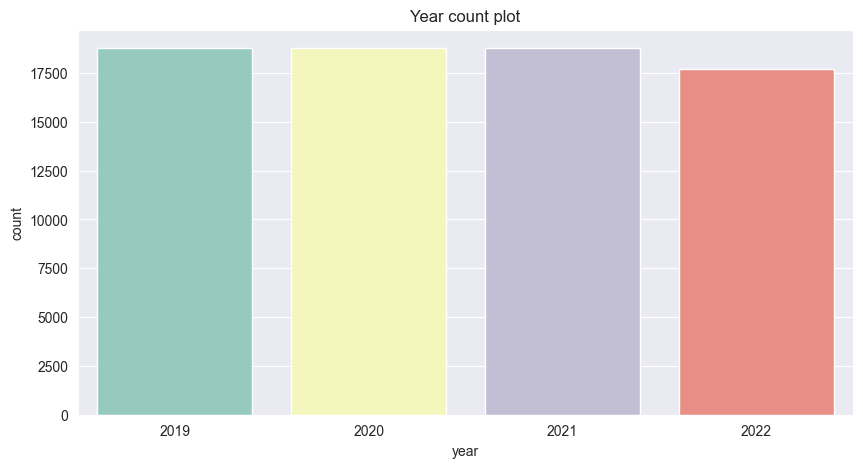

In [24]:
# Year countplot
plt.figure(figsize = (10, 5))
sns.countplot(x = 'year', data = train)
plt.title('Year count plot')
plt.show()

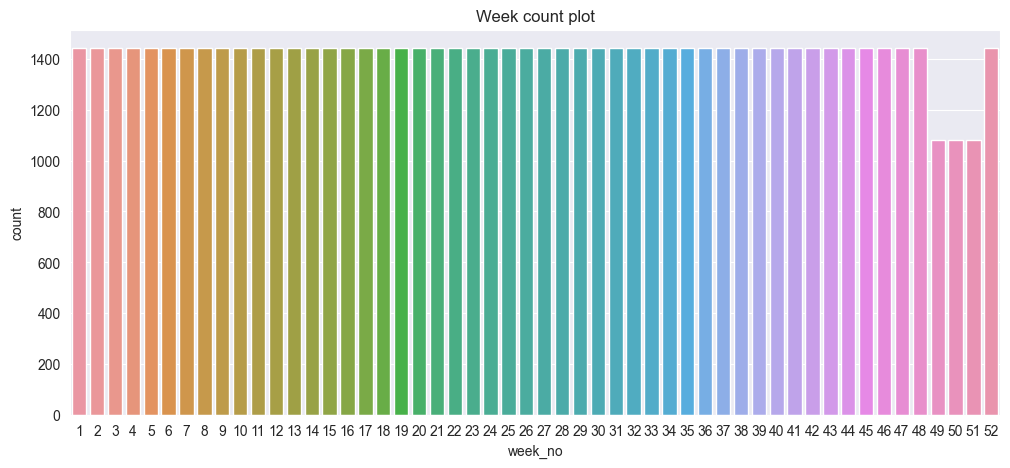

In [25]:
# Week countplot
plt.figure(figsize = (12, 5))
sns.countplot(x = 'week_no', data = train)
plt.title('Week count plot')
plt.show()

In [26]:
train.drop_duplicates(subset = ['year', 'week_no']).groupby(['year'])[['week_no']].count()

,week_no
year,
2019,52
2020,52
2021,52
2022,49


## 8. Correlations - EDA

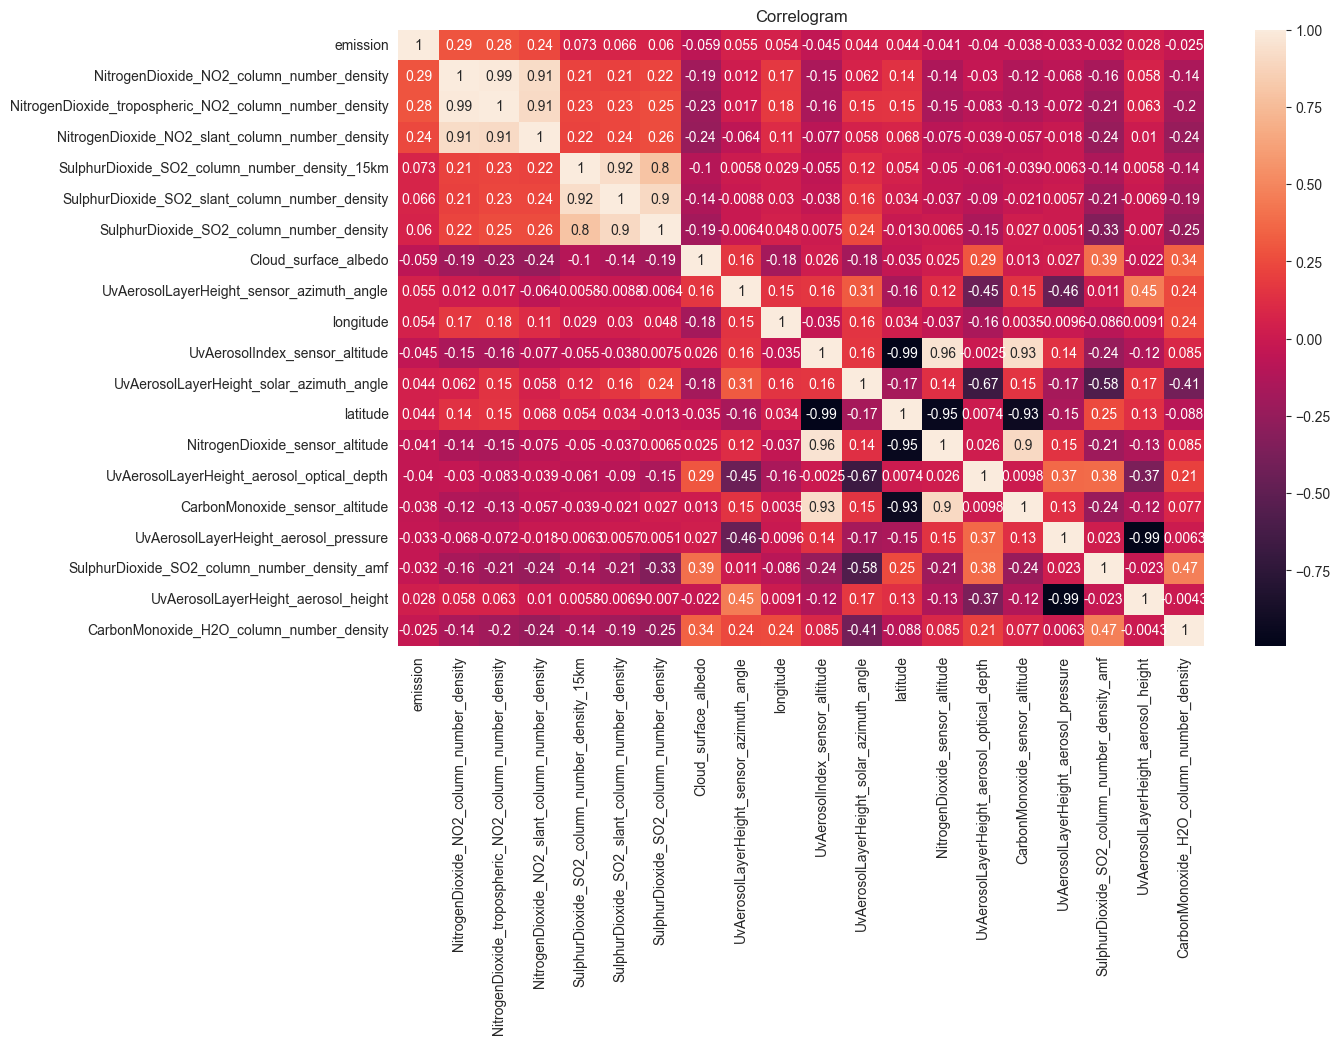

In [27]:
# Quantify correlations between features
top20_corrs = abs(train.corr(numeric_only=True)[
                  TARGET]).sort_values(ascending=False).head(20)

corr = train[list(top20_corrs.index)].corr()
plt.figure(figsize=(13, 8))
sns.heatmap(corr, annot=True)
plt.show()

## 9. Timeseries visualization - EDA

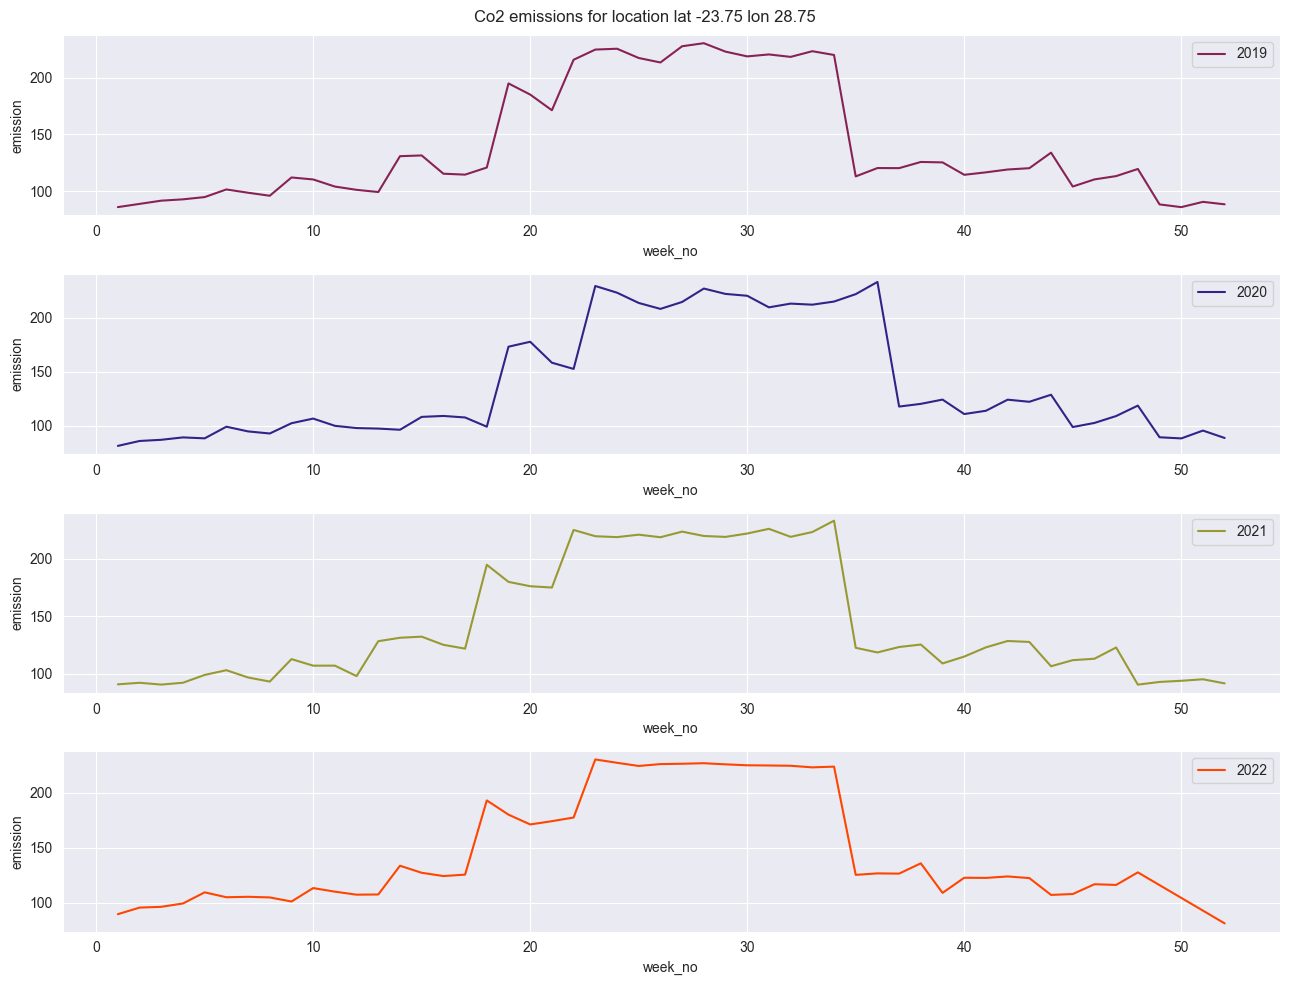

In [28]:
# Sample a unique location and visualize its emissions across the years
train['latitude'] = round(train['latitude'], 2)
train['longitude'] = round(train['longitude'], 2)
sample_loc = train[(train['latitude'] == -23.73) &
                   (train['longitude'] == 28.77)]

# Plot a line plot
fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(13, 10))
fig.suptitle('Co2 emissions for location lat -23.75 lon 28.75')

for ax, data, year, color, in zip(axes.flatten(), sample_loc, sample_loc['year'].unique(), ['#882255', '#332288', '#999933', 'orangered']):
    df = sample_loc[sample_loc['year'] == year]
    sns.lineplot(data=train, x=df['week_no'],
                 y=df[TARGET], ax=ax, label=year, color=color)
plt.legend()
plt.tight_layout()

## 10. Feature engineering

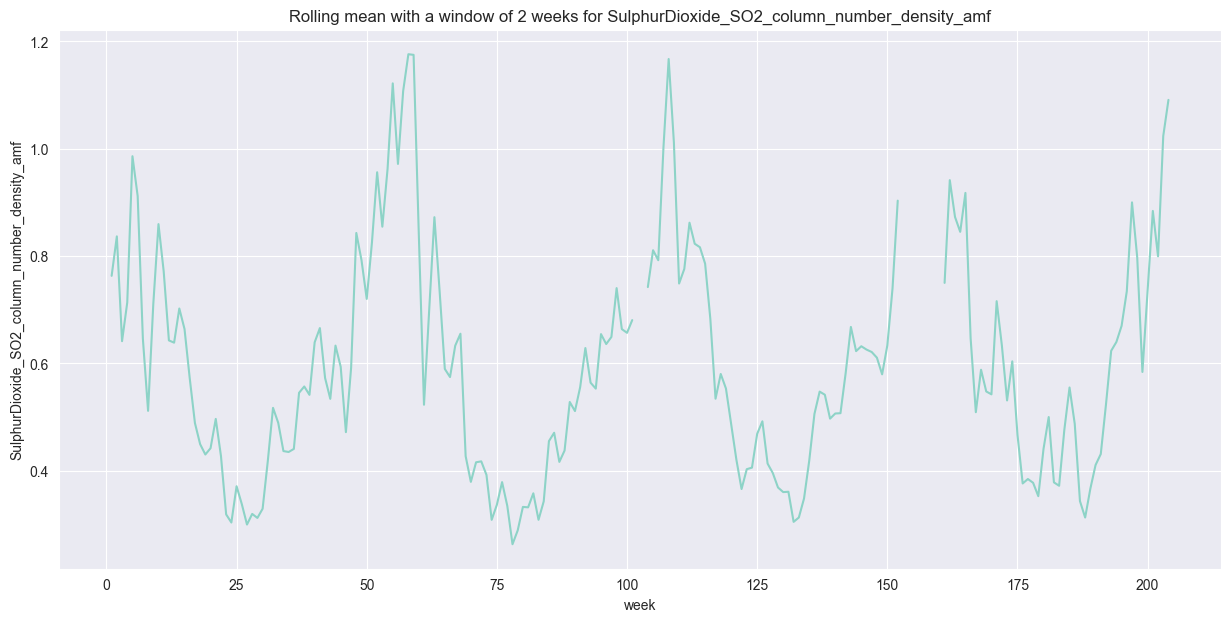

In [29]:
# Lets explore the rolling mean
# First we create a unique location from lat lon
train['location'] = [str(x) + '_' + str(y) for x, y in zip(train['latitude'], train['longitude'])]

# Filter based on one location
example_loc = train[train['location'] == '-23.73_28.77']

# Calculate rolling mean for SulphurDioxide_SO2_column_number_density_amf with a window of 2 weeks
rolling_mean = example_loc['SulphurDioxide_SO2_column_number_density_amf'].rolling(window = 2).mean()

# Visualise rolling mean
plt.figure(figsize = (15, 7))
rolling_mean.plot()
plt.title('Rolling mean with a window of 2 weeks for SulphurDioxide_SO2_column_number_density_amf')
plt.xlabel('week')
plt.ylabel('SulphurDioxide_SO2_column_number_density_amf')
plt.show()

In [30]:
# Generate the above feature - rolling mean for all locations for both the train and test

# Feature engineering train
train_roll_mean = train.sort_values(by=['location', 'year', 'week_no']).groupby(
    ['location'])[train.columns[5:].tolist()].rolling(window=2).mean().reset_index()
train_roll_mean.drop(['level_1', 'emission', 'location'], axis=1, inplace=True)
train_roll_mean.columns = [
    col + '_roll_mean' for col in train_roll_mean.columns]

# Feature engineering test
test['latitude'], test['longitude'] = round(
    test['latitude'], 2), round(test['longitude'], 2)
test['location'] = [str(x) + '_' + str(y)
                    for x, y in zip(test['latitude'], test['longitude'])]
test_roll_mean = test.sort_values(by=['location', 'year', 'week_no']).groupby(
    ['location'])[test.columns[5:].tolist()].rolling(window=2).mean().reset_index()
test_roll_mean.drop(['level_1', 'location'], axis=1, inplace=True)
test_roll_mean.columns = [col + '_roll_mean' for col in test_roll_mean.columns]
test_roll_mean.head()


,SulphurDioxide_SO2_column_number_density_roll_mean,SulphurDioxide_SO2_column_number_density_amf_roll_mean,SulphurDioxide_SO2_slant_column_number_density_roll_mean,SulphurDioxide_cloud_fraction_roll_mean,SulphurDioxide_sensor_azimuth_angle_roll_mean,SulphurDioxide_sensor_zenith_angle_roll_mean,SulphurDioxide_solar_azimuth_angle_roll_mean,SulphurDioxide_solar_zenith_angle_roll_mean,SulphurDioxide_SO2_column_number_density_15km_roll_mean,CarbonMonoxide_CO_column_number_density_roll_mean,CarbonMonoxide_H2O_column_number_density_roll_mean,CarbonMonoxide_cloud_height_roll_mean,CarbonMonoxide_sensor_altitude_roll_mean,CarbonMonoxide_sensor_azimuth_angle_roll_mean,CarbonMonoxide_sensor_zenith_angle_roll_mean,CarbonMonoxide_solar_azimuth_angle_roll_mean,CarbonMonoxide_solar_zenith_angle_roll_mean,NitrogenDioxide_NO2_column_number_density_roll_mean,NitrogenDioxide_tropospheric_NO2_column_number_density_roll_mean,NitrogenDioxide_stratospheric_NO2_column_number_density_roll_mean,NitrogenDioxide_NO2_slant_column_number_density_roll_mean,NitrogenDioxide_tropopause_pressure_roll_mean,NitrogenDioxide_absorbing_aerosol_index_roll_mean,NitrogenDioxide_cloud_fraction_roll_mean,NitrogenDioxide_sensor_altitude_roll_mean,NitrogenDioxide_sensor_azimuth_angle_roll_mean,NitrogenDioxide_sensor_zenith_angle_roll_mean,NitrogenDioxide_solar_azimuth_angle_roll_mean,NitrogenDioxide_solar_zenith_angle_roll_mean,Formaldehyde_tropospheric_HCHO_column_number_density_roll_mean,Formaldehyde_tropospheric_HCHO_column_number_density_amf_roll_mean,Formaldehyde_HCHO_slant_column_number_density_roll_mean,Formaldehyde_cloud_fraction_roll_mean,Formaldehyde_solar_zenith_angle_roll_mean,Formaldehyde_solar_azimuth_angle_roll_mean,Formaldehyde_sensor_zenith_angle_roll_mean,Formaldehyde_sensor_azimuth_angle_roll_mean,UvAerosolIndex_absorbing_aerosol_index_roll_mean,UvAerosolIndex_sensor_altitude_roll_mean,UvAerosolIndex_sensor_azimuth_angle_roll_mean,UvAerosolIndex_sensor_zenith_angle_roll_mean,UvAerosolIndex_solar_azimuth_angle_roll_mean,UvAerosolIndex_solar_zenith_angle_roll_mean,Ozone_O3_column_number_density_roll_mean,Ozone_O3_column_number_density_amf_roll_mean,Ozone_O3_slant_column_number_density_roll_mean,Ozone_O3_effective_temperature_roll_mean,Ozone_cloud_fraction_roll_mean,Ozone_sensor_azimuth_angle_roll_mean,Ozone_sensor_zenith_angle_roll_mean,Ozone_solar_azimuth_angle_roll_mean,Ozone_solar_zenith_angle_roll_mean,UvAerosolLayerHeight_aerosol_height_roll_mean,UvAerosolLayerHeight_aerosol_pressure_roll_mean,UvAerosolLayerHeight_aerosol_optical_depth_roll_mean,UvAerosolLayerHeight_sensor_zenith_angle_roll_mean,UvAerosolLayerHeight_sensor_azimuth_angle_roll_mean,UvAerosolLayerHeight_solar_azimuth_angle_roll_mean,UvAerosolLayerHeight_solar_zenith_angle_roll_mean,Cloud_cloud_fraction_roll_mean,Cloud_cloud_top_pressure_roll_mean,Cloud_cloud_top_height_roll_mean,Cloud_cloud_base_pressure_roll_mean,Cloud_cloud_base_height_roll_mean,Cloud_cloud_optical_depth_roll_mean,Cloud_surface_albedo_roll_mean,Cloud_sensor_azimuth_angle_roll_mean,Cloud_sensor_zenith_angle_roll_mean,Cloud_solar_azimuth_angle_roll_mean,Cloud_solar_zenith_angle_roll_mean
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.000129,0.438820,0.000048,0.094695,-49.026000,55.935104,-92.364110,26.771698,0.000020,0.025489,2265.509526,825.506467,836164.043391,-68.503061,42.947479,-92.938253,26.921882,0.000075,0.000033,0.000041,0.000157,9183.985574,-1.185398,0.062243,835556.726552,7.386257,55.926608,-89.234521,19.556248,0.000202,0.976496,0.000122,0.101812,26.905807,-92.465549,55.678580,-50.946999,-0.882496,835941.380262,-29.637287,51.397448,-91.441108,23.898942,0.120184,2.852682,0.347372,229.000707,0.191387,-45.886237,50.962113,-92.252723,25.979651,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.235195,

In [31]:
# Merge engineered features with train and test set

# Train
train_eng = train.sort_values(by=['location', 'year', 'week_no'], ignore_index=True).merge(
    train_roll_mean, how='left', left_index=True, right_index=True)

# Test
test_eng = test.sort_values(by=['location', 'year', 'week_no'], ignore_index=True).merge(
    test_roll_mean, how='left', left_index=True, right_index=True)

# Preview engineered test set
test_eng.head()

,ID_LAT_LON_YEAR_WEEK,latitude,longitude,year,week_no,SulphurDioxide_SO2_column_number_density,SulphurDioxide_SO2_column_number_density_amf,SulphurDioxide_SO2_slant_column_number_density,SulphurDioxide_cloud_fraction,SulphurDioxide_sensor_azimuth_angle,SulphurDioxide_sensor_zenith_angle,SulphurDioxide_solar_azimuth_angle,SulphurDioxide_solar_zenith_angle,SulphurDioxide_SO2_column_number_density_15km,CarbonMonoxide_CO_column_number_density,CarbonMonoxide_H2O_column_number_density,CarbonMonoxide_cloud_height,CarbonMonoxide_sensor_altitude,CarbonMonoxide_sensor_azimuth_angle,CarbonMonoxide_sensor_zenith_angle,CarbonMonoxide_solar_azimuth_angle,CarbonMonoxide_solar_zenith_angle,NitrogenDioxide_NO2_column_number_density,NitrogenDioxide_tropospheric_NO2_column_number_density,NitrogenDioxide_stratospheric_NO2_column_number_density,NitrogenDioxide_NO2_slant_column_number_density,NitrogenDioxide_tropopause_pressure,NitrogenDioxide_absorbing_aerosol_index,NitrogenDioxide_cloud_fraction,NitrogenDioxide_sensor_altitude,NitrogenDioxide_sensor_azimuth_angle,NitrogenDioxide_sensor_zenith_angle,NitrogenDioxide_solar_azimuth_angle,NitrogenDioxide_solar_zenith_angle,Formaldehyde_tropospheric_HCHO_column_number_density,Formaldehyde_tropospheric_HCHO_column_number_density_amf,Formaldehyde_HCHO_slant_column_number_density,Formaldehyde_cloud_fraction,Formaldehyde_solar_zenith_angle,Formaldehyde_solar_azimuth_angle,Formaldehyde_sensor_zenith_angle,Formaldehyde_sensor_azimuth_angle,UvAerosolIndex_absorbing_aerosol_index,UvAerosolIndex_sensor_altitude,UvAerosolIndex_sensor_azimuth_angle,UvAerosolIndex_sensor_zenith_angle,UvAerosolIndex_solar_azimuth_angle,UvAerosolIndex_solar_zenith_angle,Ozone_O3_column_number_density,Ozone_O3_column_number_density_amf,...,NitrogenDioxide_NO2_slant_column_number_density_roll_mean,NitrogenDioxide_tropopause_pressure_roll_mean,NitrogenDioxide_absorbing_aerosol_index_roll_mean,NitrogenDioxide_cloud_fraction_roll_mean,NitrogenDioxide_sensor_altitude_roll_mean,NitrogenDioxide_sensor_azimuth_angle_roll_mean,NitrogenDioxide_sensor_zenith_angle_roll_mean,NitrogenDioxide_solar_azimuth_angle_roll_mean,NitrogenDioxide_solar_zenith_angle_roll_mean,Formaldehyde_tropospheric_HCHO_column_number_density_roll_mean,Formaldehyde_tropospheric_HCHO_column_number_density_amf_roll_mean,Formaldehyde_HCHO_slant_column_number_density_roll_mean,Formaldehyde_cloud_fraction_roll_mean,Formaldehyde_solar_zenith_angle_roll_mean,Formaldehyde_solar_azimuth_angle_roll_mean,Formaldehyde_sensor_zenith_angle_roll_mean,Formaldehyde_sensor_azimuth_angle_roll_mean,UvAerosolIndex_absorbing_aerosol_index_roll_mean,UvAerosolIndex_sensor_altitude_roll_mean,UvAerosolIndex_sensor_azimuth_angle_roll_mean,UvAerosolIndex_sensor_zenith_angle_roll_mean,UvAerosolIndex_solar_azimuth_angle_roll_mean,UvAerosolIndex_solar_zenith_angle_roll_mean,Ozone_O3_column_number_density_roll_mean,Ozone_O3_column_number_density_amf_roll_mean,Ozone_O3_slant_column_number_density_roll_mean,Ozone_O3_effective_temperature_roll_mean,Ozone_cloud_fraction_roll_mean,Ozone_sensor_azimuth_angle_roll_mean,Ozone_sensor_zenith_angle_roll_mean,Ozone_solar_azimuth_angle_roll_mean,Ozone_solar_zenith_angle_roll_mean,UvAerosolLayerHeight_aerosol_height_roll_mean,UvAerosolLayerHeight_aerosol_pressure_roll_mean,UvAerosolLayerHeight_aerosol_optical_depth_roll_mean,UvAerosolLayerHeight_sensor_zenith_angle_roll_mean,UvAerosolLayerHeight_sensor_azimuth_angle_roll_mean,UvAerosolLayerHeight_solar_azimuth_angle_roll_mean,UvAerosolLayerHeight_solar_zenith_angle_roll_mean,Cloud_cloud_fraction_roll_mean,Cloud_cloud_top_pressure_roll_mean,Cloud_cloud_top_height_roll_mean,Cloud_cloud_base_pressure_roll_mean,Cloud_cloud_base_height_roll_mean,Cloud_cloud_optical_depth_roll_mean,Cloud_surface_albedo_roll_mean,Cloud_sensor_azimuth_angle_roll_mean,Cloud_sensor_zenith_angle_roll_mean,Cloud_solar_azimuth_angle_roll_mean,Cloud_solar_zenith_angle_roll_mean
0,ID_-23.53_27.47_2019_1,-23.53,27.47,2019,1,0.000077,0.454468,0.00003

<a name="Modelling"></a>
## 11.  Modelling

In [59]:
params = {
    'n_estimators': 3000,
    'learning_rate': 0.1,
    'objective': 'RMSE',
    'rsm': 0.7,
    'random_seed': SEED,
    'early_stopping_rounds': 200,
    'use_best_model': True,
}

In [60]:
# Instantiating the models
XGB = XGBRegressor(random_state = SEED, n_jobs=-1)
LGBM = LGBMRegressor(random_state = SEED, n_jobs=-1)
CB = CatBoostRegressor(**params)

In [35]:
def preprocessing_data(data: pd.DataFrame) -> pd.DataFrame:
    ''' Réalise la phase de pré-traitement d'un dataset à savoir l'encodage 
    des variables discrètes et la normalisation de toutes les variables 
    '''
    # copie du dataset
    data1 = data.copy()
    # la liste des colonnes discrètes
    return data1

In [61]:
train_eng_pp = preprocessing_data(train_eng)
test_eng_pp = preprocessing_data(test_eng)
# Selecting the independent variables and the target variable
X = train_eng_pp.drop([ID, 'location', TARGET], axis = 1)
y = train_eng_pp[TARGET]
# spliting
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = SEED)

In [64]:
def model_prediction(model):
	''' détermine la prediction d'un modèle
	'''
	model.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=100)
	y_pred = model.predict(X_test)
	print(f'RMSE Score : {mean_squared_error(y_test, y_pred, squared=False)}')
	return y_pred

Test du modèle sur le train set

In [65]:
model = CB
y_pred = model_prediction(model)

0:	learn: 47908.4863770	test: 48335.9537961	best: 48335.9537961 (0)	total: 177ms	remaining: 8m 50s
100:	learn: 9019.3926574	test: 10207.3883600	best: 10207.3883600 (100)	total: 5.95s	remaining: 2m 50s
200:	learn: 6450.3249033	test: 8217.9431272	best: 8217.9431272 (200)	total: 11.2s	remaining: 2m 35s
300:	learn: 5286.1104192	test: 7389.3716767	best: 7389.3716767 (300)	total: 16.5s	remaining: 2m 27s
400:	learn: 4605.5715729	test: 7041.6606837	best: 7041.6606837 (400)	total: 21.7s	remaining: 2m 20s
500:	learn: 4132.7001893	test: 6876.4194748	best: 6875.3460565 (498)	total: 26.9s	remaining: 2m 14s
600:	learn: 3782.0425425	test: 6771.8527952	best: 6771.8527952 (600)	total: 32.2s	remaining: 2m 8s
700:	learn: 3501.9628266	test: 6696.7859631	best: 6696.4392278 (699)	total: 37.4s	remaining: 2m 2s
800:	learn: 3199.9130211	test: 6585.8805674	best: 6585.7709943 (799)	total: 42.6s	remaining: 1m 57s
900:	learn: 3003.6285039	test: 6553.0538851	best: 6553.0509984 (898)	total: 47.8s	remaining: 1m 51s
1

Analyse des prédictions

In [66]:
pred_errors = X_test.copy()
pred_errors[TARGET] = y_test
pred_errors['prediction'] = y_pred
pred_errors['error'] = abs(pred_errors['prediction'] - pred_errors[TARGET])
pred_errors = pred_errors[['latitude', 'longitude',
                           'year',	'week_no', TARGET, 'prediction', 'error']]
pred_errors.sort_values(by='error', ascending=False, inplace=True)
pred_errors

,latitude,longitude,year,week_no,emission,prediction,error
20345,-25.93,29.37,2019,51,1.002098e+06,806762.983360,195335.266640
20303,-25.93,29.37,2019,9,1.030984e+06,837098.670441,193885.079559
20425,-25.93,29.37,2021,27,1.123932e+06,933296.697421,190634.902579
20304,-25.93,29.37,2019,10,1.038997e+06,848605.979468,190391.080532
20374,-25.93,29.37,2020,28,1.096334e+06,918861.544715,177472.455285
...,...,...,...,...,...,...,...
17468,-25.63,27.17,2019,44,3.210678e+03,3210.535346,0.142354
3250,-23.83,29.27,2022,20,1.252169e+03,1252.034182,0.134518
69297,-31.93,28.67,2019,8,6.595691e+02,659.464799,0.104301
71023,-32.83,27.87,2020,42,3.523497e+02,352.398995,0.049265


In [67]:
pred_errors.error.sum()

29554976.777663235

Niveaux d'importance des features pris en compte par le modèle

In [68]:
model.feature_importances_[model.feature_importances_ > 0].size

144

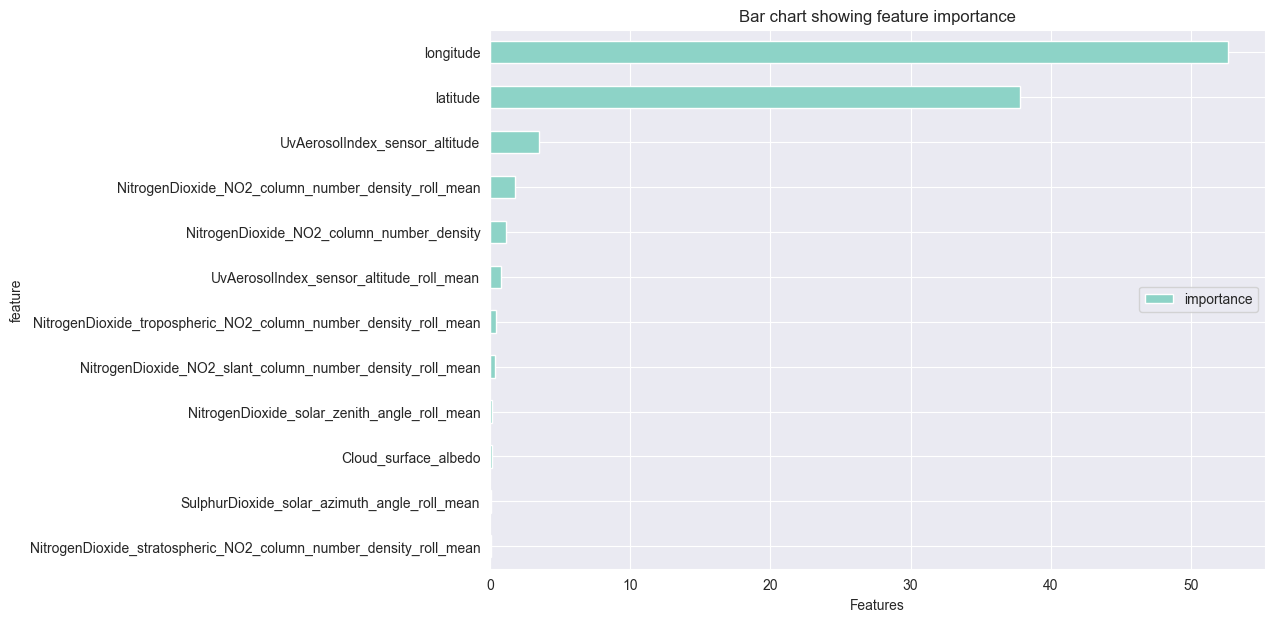

In [69]:
impo_df = pd.DataFrame({'feature': X.columns, 'importance': model.feature_importances_}).set_index(
    'feature').sort_values(by='importance', ascending=False)
impo_df_12 = impo_df[:12].sort_values(by='importance', ascending=True)
impo_df_12.plot(kind='barh', figsize=(10, 7))
plt.legend(loc='center right')
plt.title('Bar chart showing feature importance')
plt.xlabel('Features')
plt.show()


In [70]:
len(impo_df[impo_df.importance > 4].index.to_list())

2

In [71]:
train_selected = train_eng_pp[impo_df[impo_df.importance > 4].index.to_list()]

test_selected = test_eng_pp[impo_df[impo_df.importance > 4].index.to_list()]

display(train_selected.head(), test_selected.head())

,longitude,latitude
0,28.77,-23.73
1,28.77,-23.73
2,28.77,-23.73
3,28.77,-23.73
4,28.77,-23.73


,longitude,latitude
0,27.47,-23.53
1,27.47,-23.53
2,27.47,-23.53
3,27.47,-23.53
4,27.47,-23.53


Réentraînement après le feature engineering

In [75]:
X_selected = train_selected
y_selected = train_eng_pp[TARGET]
# spliting
X_train_selected, X_test_selected, y_train_selected, y_test_selected = train_test_split(X_selected, y_selected, test_size = 0.3, random_state = SEED)

In [77]:
CB.fit(X_train_selected, y_train_selected, eval_set=[(X_test_selected, y_test_selected)], verbose=100)
y_pred = CB.predict(X_test_selected)
print(f'RMSE Score : {mean_squared_error(y_test_selected, y_pred, squared=False)}')

0:	learn: 47734.1719680	test: 48090.3810801	best: 48090.3810801 (0)	total: 31.6ms	remaining: 1m 34s
100:	learn: 10622.2787376	test: 10890.3663704	best: 10890.3663704 (100)	total: 951ms	remaining: 27.3s
200:	learn: 7788.6037358	test: 8059.1676467	best: 8059.1676467 (200)	total: 1.8s	remaining: 25.1s
300:	learn: 7136.9769916	test: 7433.6639869	best: 7433.6639869 (300)	total: 2.54s	remaining: 22.8s
400:	learn: 6900.5224613	test: 7214.4439498	best: 7214.4439498 (400)	total: 3.27s	remaining: 21.2s
500:	learn: 6819.4136371	test: 7145.7047439	best: 7145.7047439 (500)	total: 3.97s	remaining: 19.8s
600:	learn: 6743.0967714	test: 7072.7391947	best: 7072.7391947 (600)	total: 4.69s	remaining: 18.7s
700:	learn: 6701.5454965	test: 7033.9440215	best: 7033.9440215 (700)	total: 5.41s	remaining: 17.7s
800:	learn: 6678.7125985	test: 7011.0077156	best: 7011.0077156 (800)	total: 6.16s	remaining: 16.9s
900:	learn: 6667.2421646	test: 6998.0688326	best: 6998.0688326 (900)	total: 6.98s	remaining: 16.3s
1000:	l

In [78]:
model_selected = CB

## Submission

In [79]:
# Make prediction on the test set
test_df = test_selected
predictions = model_selected.predict(test_df)

# Create a submission file
sub_file = pd.DataFrame({ID: test_eng[ID], TARGET: predictions})
sub_file.head()

,ID_LAT_LON_YEAR_WEEK,emission
0,ID_-23.53_27.47_2019_1,2432.835725
1,ID_-23.53_27.47_2019_2,2432.835725
2,ID_-23.53_27.47_2019_3,2432.835725
3,ID_-23.53_27.47_2019_4,2432.835725
4,ID_-23.53_27.47_2019_5,2432.835725


In [80]:
# Create file
today = dt.now().strftime(format="%Y-%m-%d_%Hh%M")
sub_file.to_csv(f'soumissions/submission_{today}.csv', index=False)

## Saving model

In [82]:
# Save the model as a pickle in a file
joblib.dump(model_selected, 'models/catboost_private_9992.527662.pkl')

['models/catboost_private_9992.527662.pkl']